# Quantile Transformer

**When to use:**
- Moderate to high skewness (both left and right)
- When you want PERFECT normal or uniform distribution
- Robust to outliers
- Alternative to Power Transformers when Box-Cox/Yeo-Johnson don't work well enough

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import QuantileTransformer

import warnings
warnings.filterwarnings('ignore')

In [34]:
df = pd.read_csv('concrete_data.csv')
print(f"\nColumn names:\n{df.columns.tolist()}")
print(f"\nshape: {df.shape}")
print(f"\n\n{df.isna().sum()}\n\n")
print(f"\n {df.describe()}\n")
df.head()


Column names:
['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age', 'Strength']

shape: (1030, 9)


Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64



             Cement  Blast Furnace Slag      Fly Ash        Water  \
count  1030.000000         1030.000000  1030.000000  1030.000000   
mean    281.167864           73.895825    54.188350   181.567282   
std     104.506364           86.279342    63.997004    21.354219   
min     102.000000            0.000000     0.000000   121.800000   
25%     192.375000            0.000000     0.000000   164.900000   
50%     272.900000           22.000000     0.000000   185.000000   
75%     350.000000          142.950000   118.300000   192.000000   
max     540.000000          359.400000   200.100000   247.

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [35]:
# pirnting skewness
skewness = df.apply(stats.skew)     # this creates a pd series not list
# stats.skew - measures skewness of a data distribution
# df.apply() — applies that function to each column of the DataFrame.
skewness

Cement                0.508739
Blast Furnace Slag    0.799550
Fly Ash               0.536571
Water                 0.074520
Superplasticizer      0.905881
Coarse Aggregate     -0.040161
Fine Aggregate       -0.252641
Age                   3.264415
Strength              0.416370
dtype: float64

In [36]:
# printing skewness using for loop

print("ORIGINAL SKEWNESS OF EACH FEATURE\n")
for col, skew_val in skewness.items():
    skew_type = "RIGHT" if skew_val > 0.5 else "LEFT" if skew_val < -0.5 else "NORMAL"
    print(f"{col:25s}: {skew_val:8.3f}  [{skew_type}]")

"""
{col:25s} → 
    - 's' means it's a string.
    - '25' means the string will take up 25 character spaces.
    - If the column name is shorter, spaces are added on the right.
    - This keeps all column names aligned vertically.

{skew_val:8.3f} →
    - 'f' means fixed-point number (decimal format).
    - '8' means the total width will be 8 characters.
    - '.3' means show 3 digits after the decimal point.
    - This ensures numbers are neatly aligned in a column.

"""


print()
print("Interpretation:")
print("  > 0.5  = Right-skewed (tail extends to the right)")
print("  < -0.5 = Left-skewed (tail extends to the left)")
print(" -0.5 to 0.5 = Approximately normal")


ORIGINAL SKEWNESS OF EACH FEATURE

Cement                   :    0.509  [RIGHT]
Blast Furnace Slag       :    0.800  [RIGHT]
Fly Ash                  :    0.537  [RIGHT]
Water                    :    0.075  [NORMAL]
Superplasticizer         :    0.906  [RIGHT]
Coarse Aggregate         :   -0.040  [NORMAL]
Fine Aggregate           :   -0.253  [NORMAL]
Age                      :    3.264  [RIGHT]
Strength                 :    0.416  [NORMAL]

Interpretation:
  > 0.5  = Right-skewed (tail extends to the right)
  < -0.5 = Left-skewed (tail extends to the left)
 -0.5 to 0.5 = Approximately normal


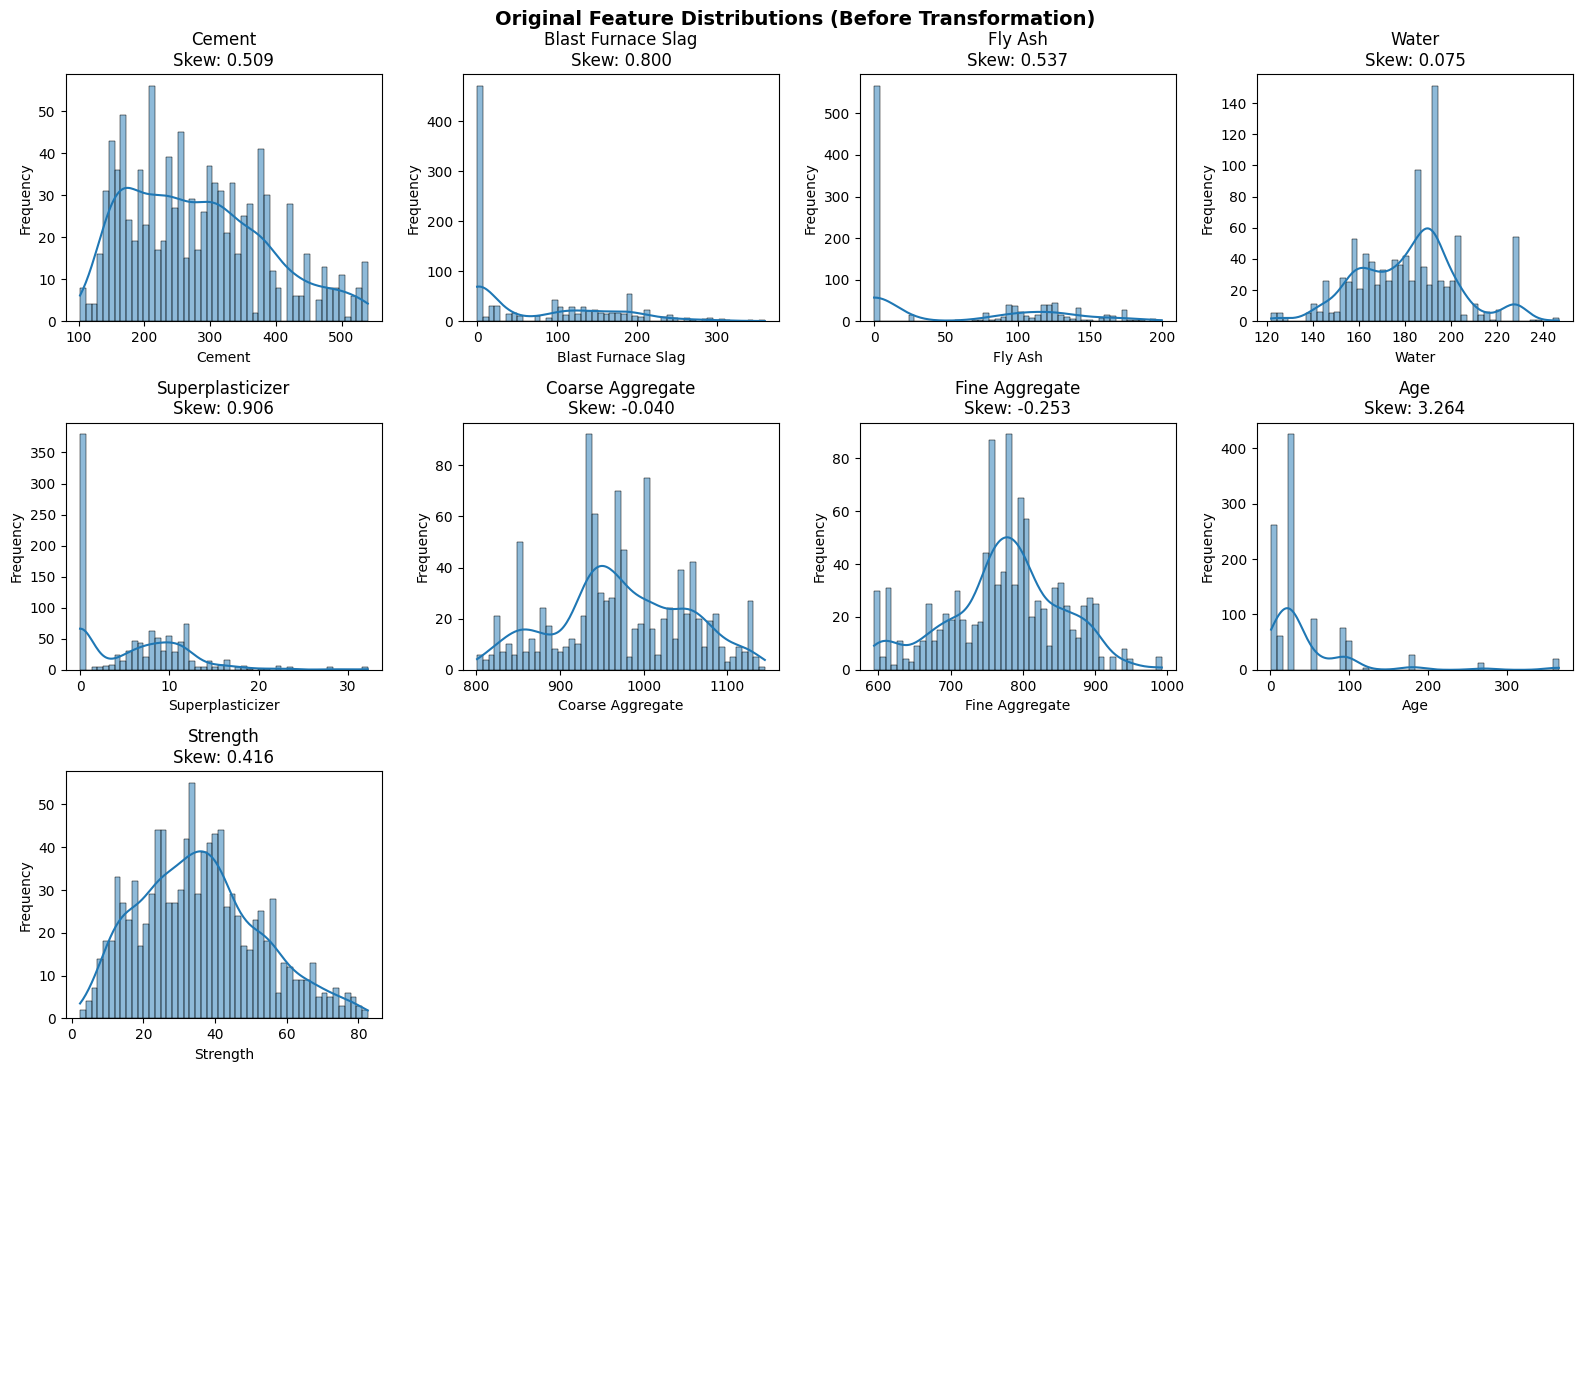

In [37]:
# Plotting the graphs
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

fig, axes = plt.subplots(4, 4, figsize=(16, 14))
axes = axes.ravel()

for i, col in enumerate(df.columns):
    # Histogram with KDE using Seaborn
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i], edgecolor='black')
    
    # Title with skewness value
    axes[i].set_title(f'{col}\nSkew: {stats.skew(df[col]):.3f}')
    axes[i].set_xlabel(f"{col}")
    axes[i].set_ylabel('Frequency')

# Hiding unused subplots
for j in range(len(df.columns), len(axes)):
    axes[j].axis('off')

plt.suptitle('Original Feature Distributions (Before Transformation)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### Using Quantile Transformers

In [38]:
x = df.drop(columns=['Strength'])
y = df['Strength']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

qt = QuantileTransformer(output_distribution='normal', random_state=42)     # will return array
x_train_transformed = qt.fit_transform(x_train)
x_test_transformed = qt.transform(x_test)

lr = LinearRegression()
lr.fit(x_train_transformed, y_train)
y_pred = lr.predict(x_test_transformed)

print(f"Accuracy : {np.round(r2_score(y_test, y_pred),2)*100} %")
print(f"Cross Val Score : {np.round(cross_val_score(lr, x_train_transformed, y_train, cv=5, scoring='r2').mean(),2)*100} %")



Accuracy : 70.0 %
Cross Val Score : 71.0 %


In [39]:
# converting the data into data frames before plotting them

data = pd.DataFrame(x_train_transformed, columns=x_train.columns)
data = pd.concat([data, y_train], axis=1)
data.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,-1.143734,0.720128,0.626504,-0.356121,1.523707,-0.200837,-0.714220,0.045702,79.99
1,1.109268,-0.001523,1.103650,-0.265001,0.339942,-2.065432,-0.458747,0.045702,61.89
2,0.003046,-5.199338,0.762219,-0.937067,0.588047,0.890820,-0.039605,-1.481334,NaN
3,-0.089970,0.250832,0.200837,0.807813,0.269736,-1.722082,0.665911,0.045702,NaN
4,-0.888558,0.094558,0.918333,-1.057242,0.762219,1.356407,0.306247,-1.481334,44.30


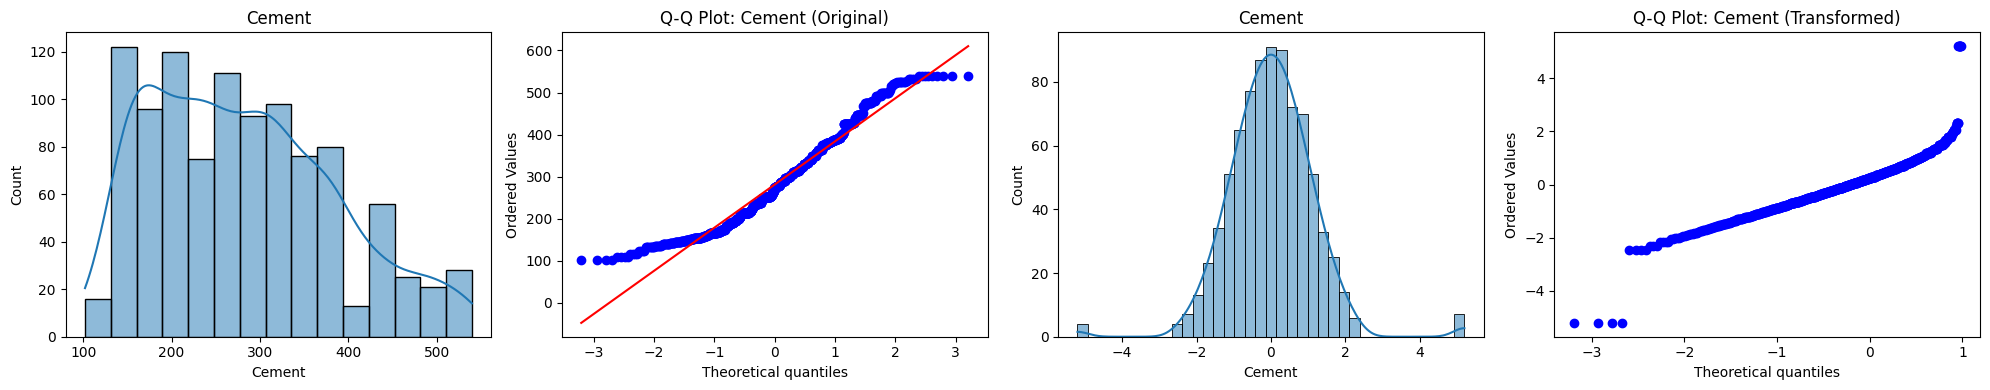

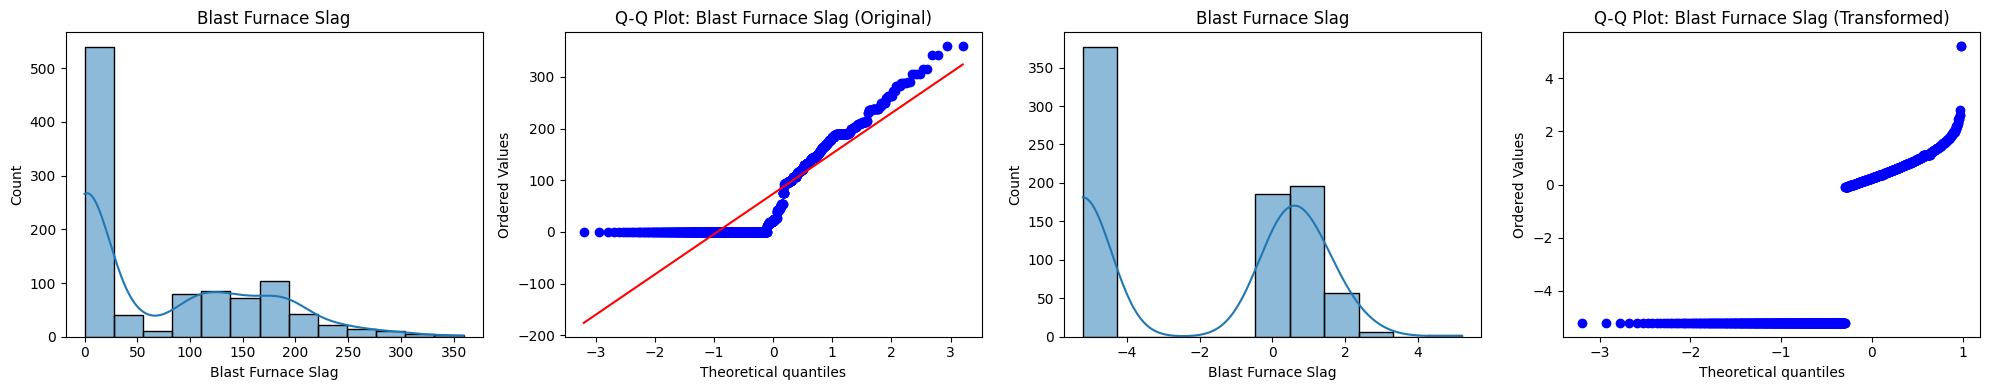

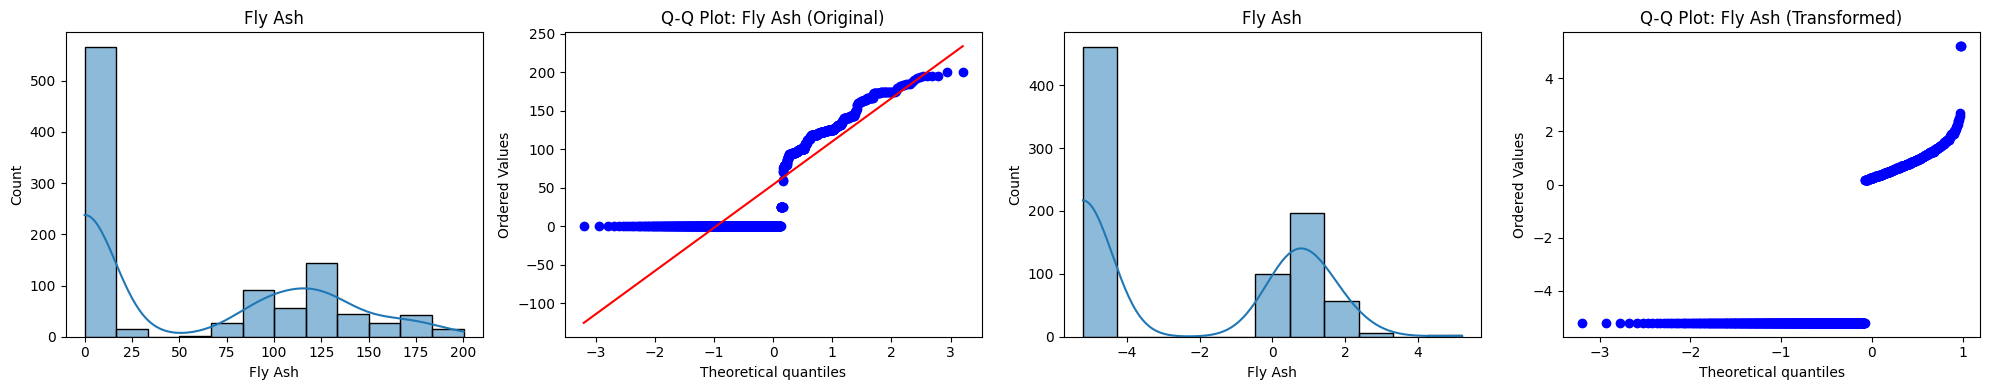

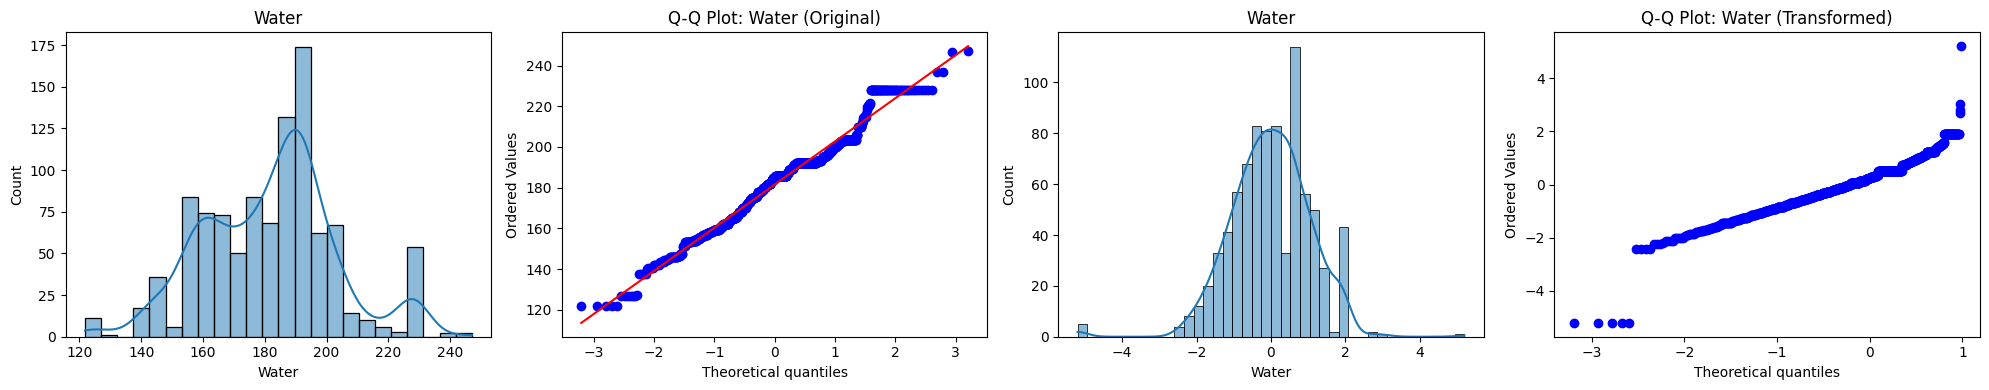

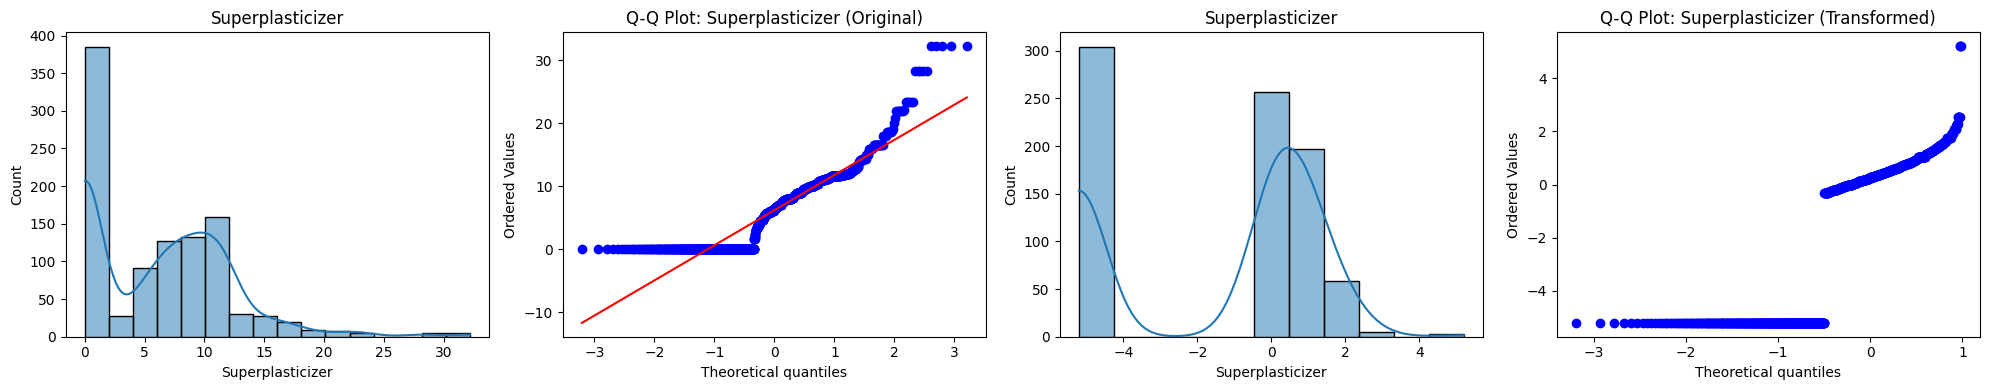

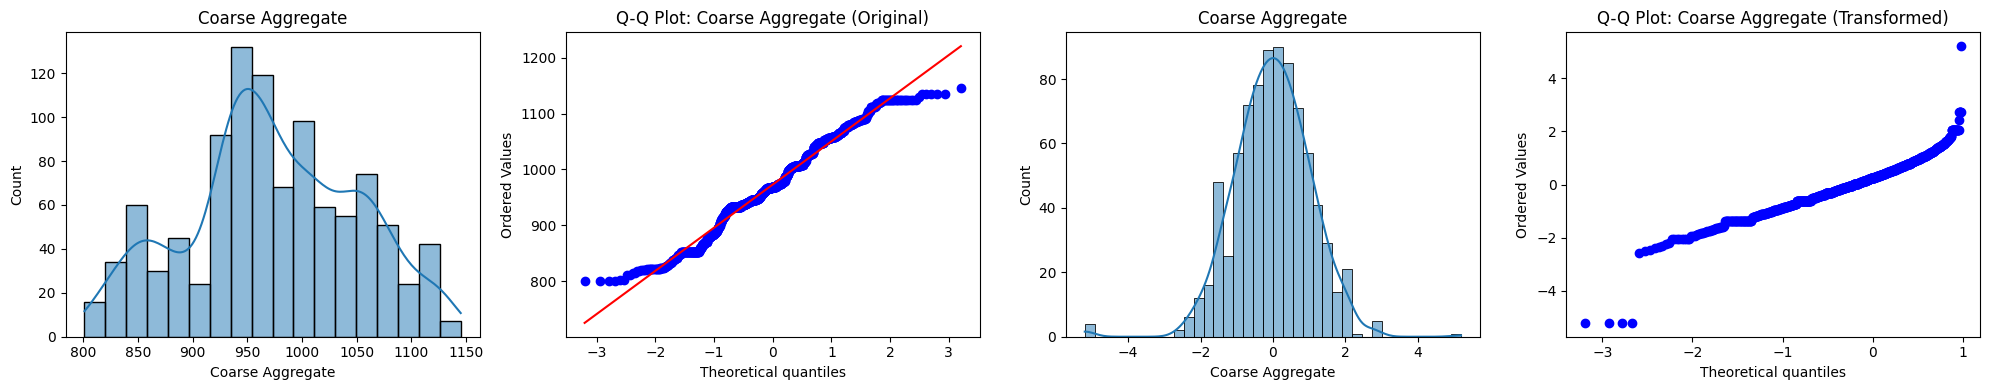

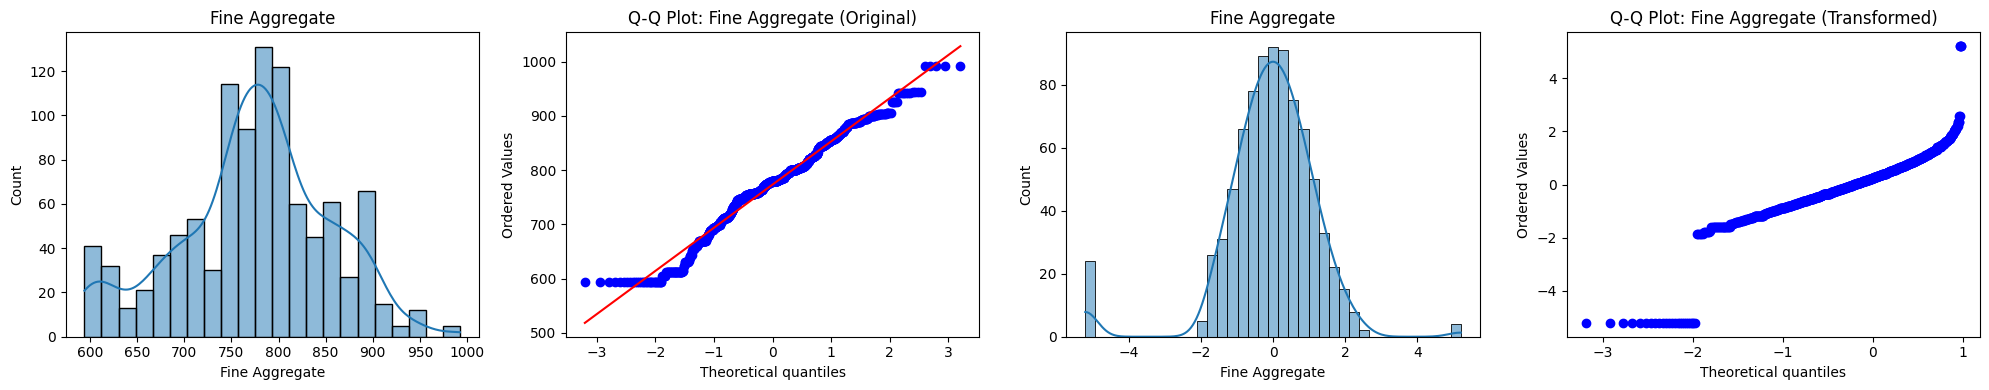

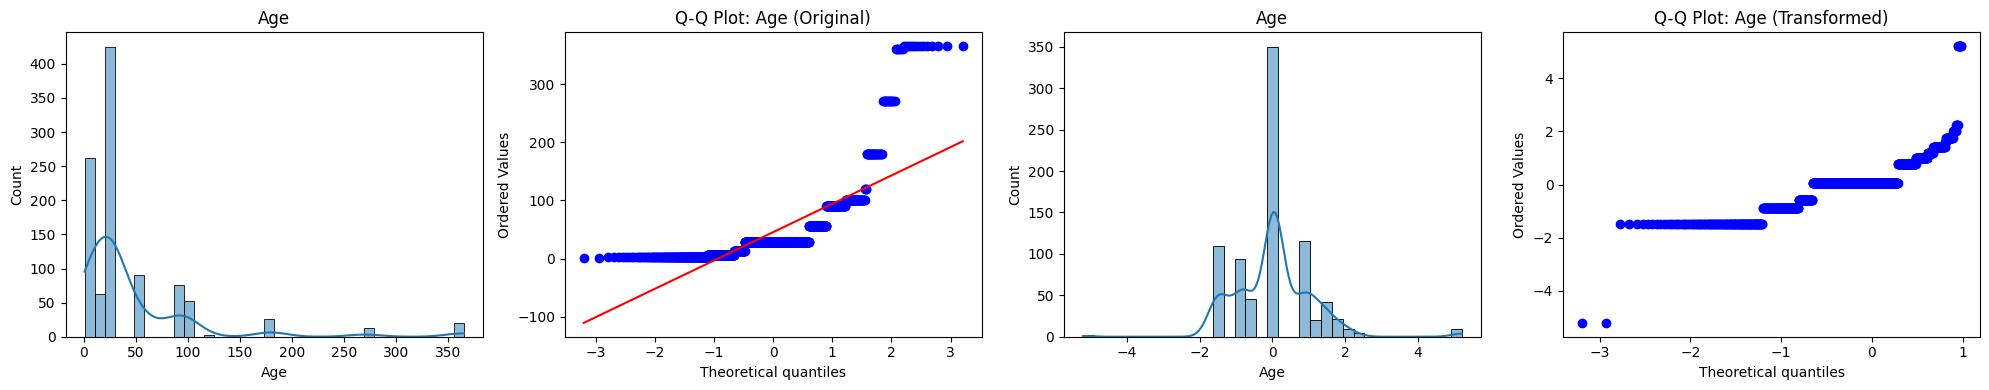

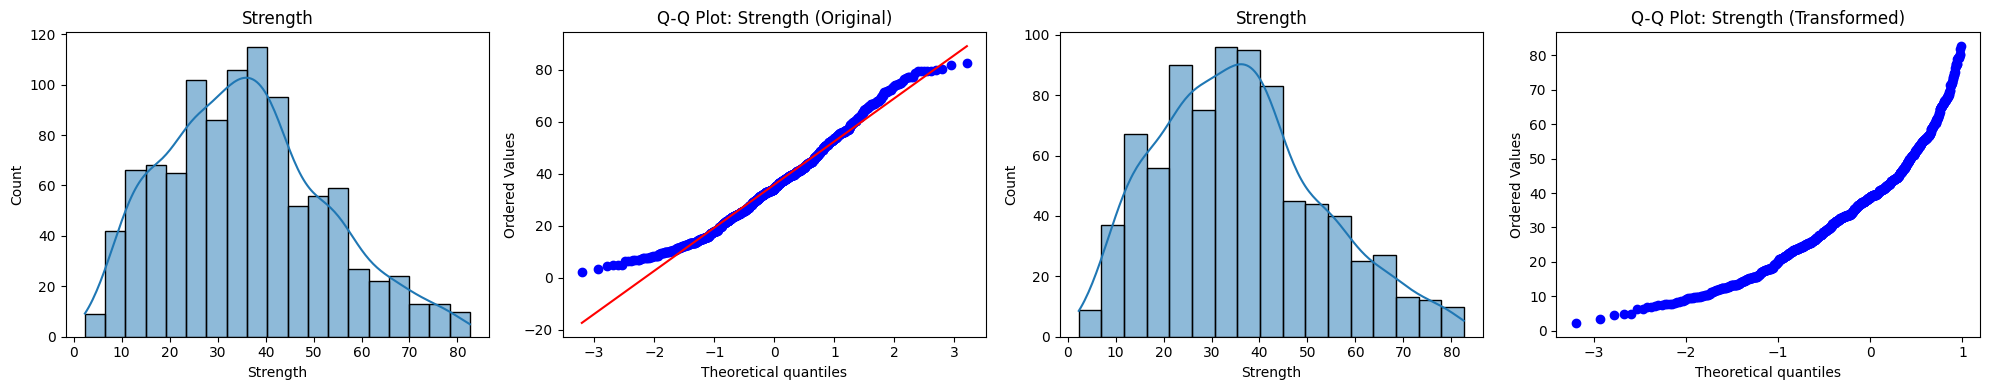

In [40]:
# plotting the graphs

for col in data.columns:
    plt.figure(figsize=(20,4))

    plt.subplot(1,4,1)
    sns.histplot(df[col], kde=True)
    plt.title(f"{col}")

    plt.subplot(1,4,2)
    stats.probplot(df[col], dist='norm', plot=plt)
    plt.title(f"Q-Q Plot: {col} (Original)")

    plt.subplot(1,4,3)
    sns.histplot(data[col], kde=True)
    plt.title(f"{col}")

    plt.subplot(1,4,4)
    stats.probplot(data[col], dist='norm', plot=plt)
    plt.title(f"Q-Q Plot: {col} (Transformed)")

    plt.tight_layout()
    plt.show()

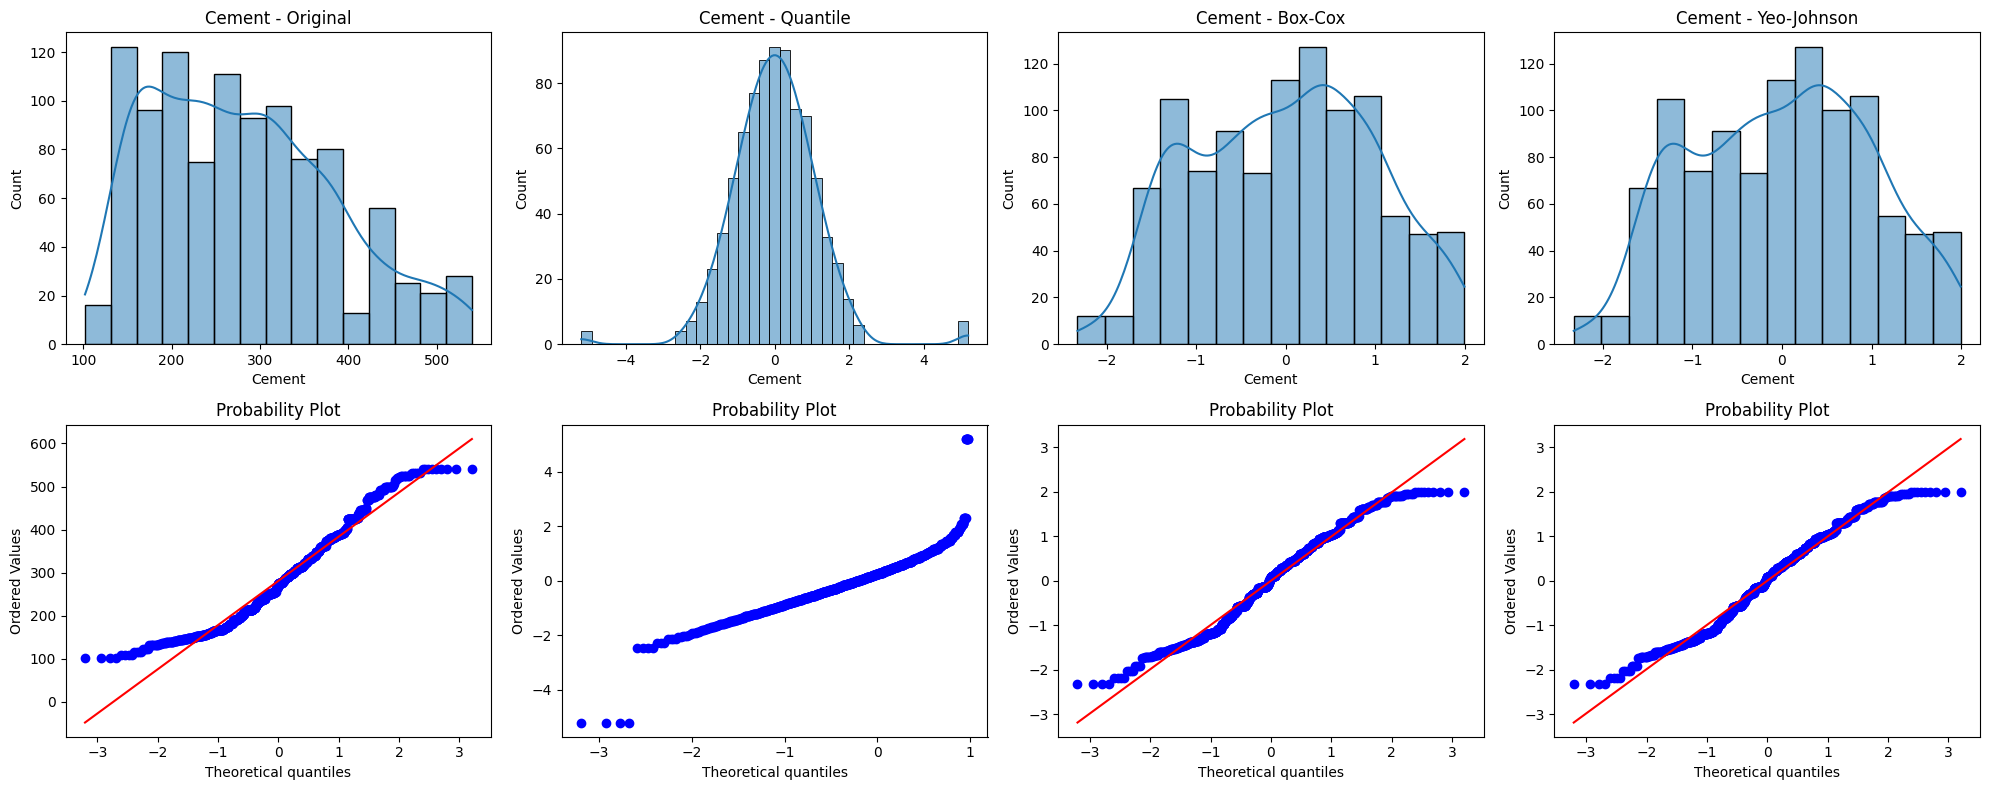

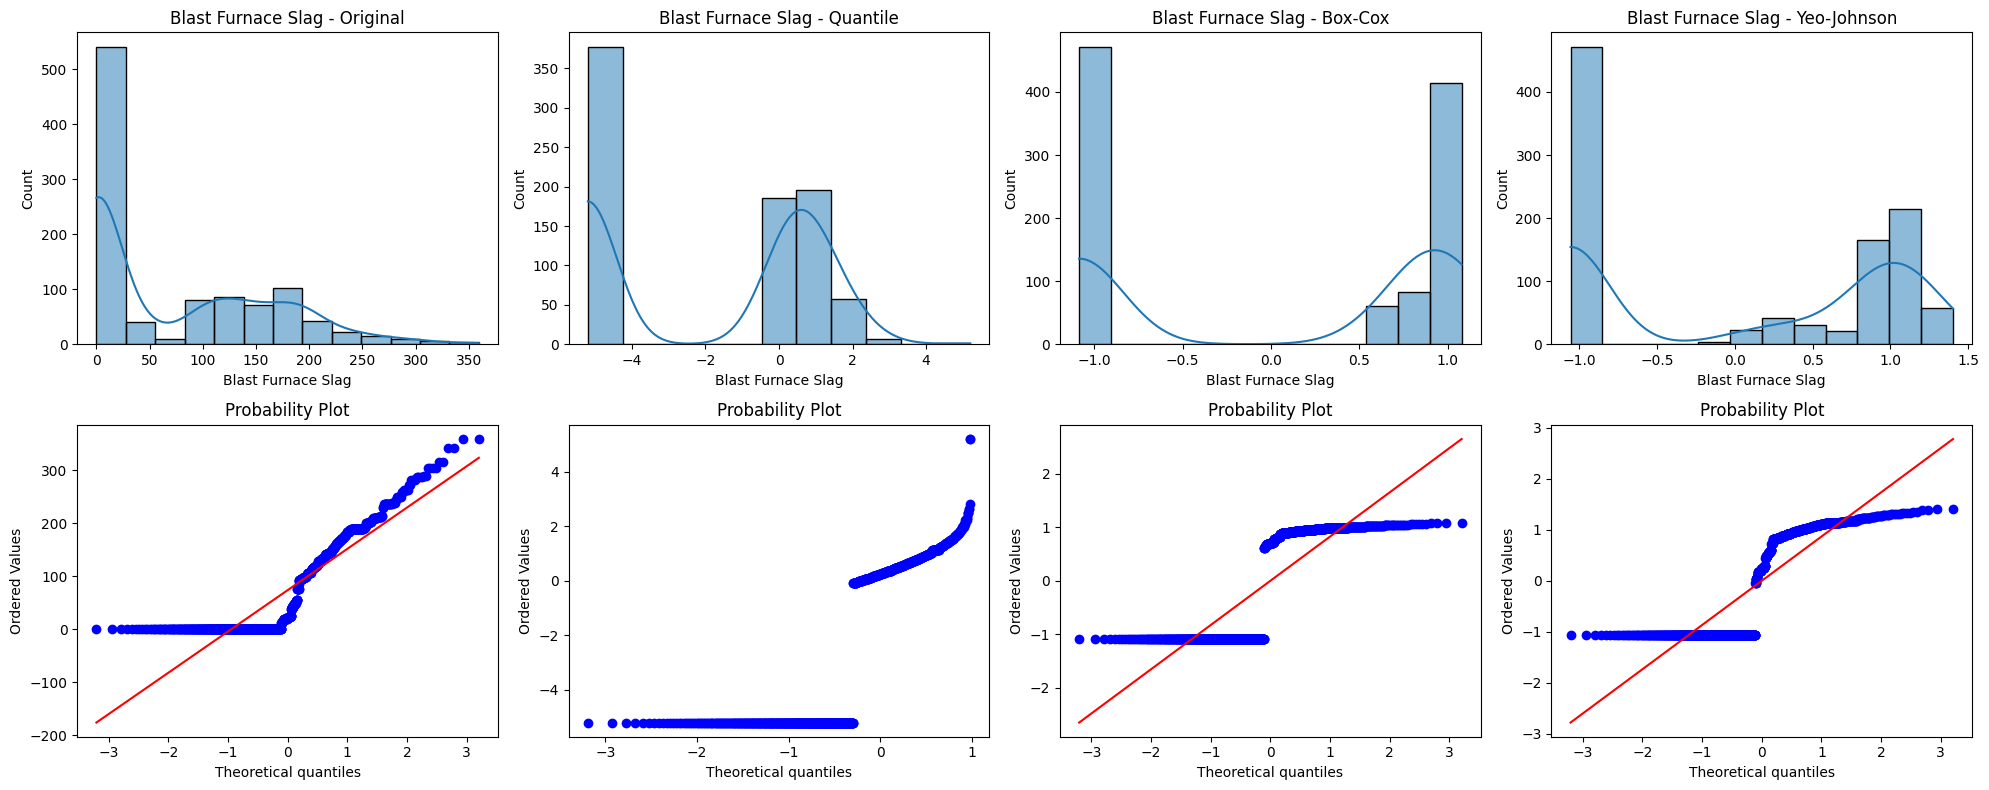

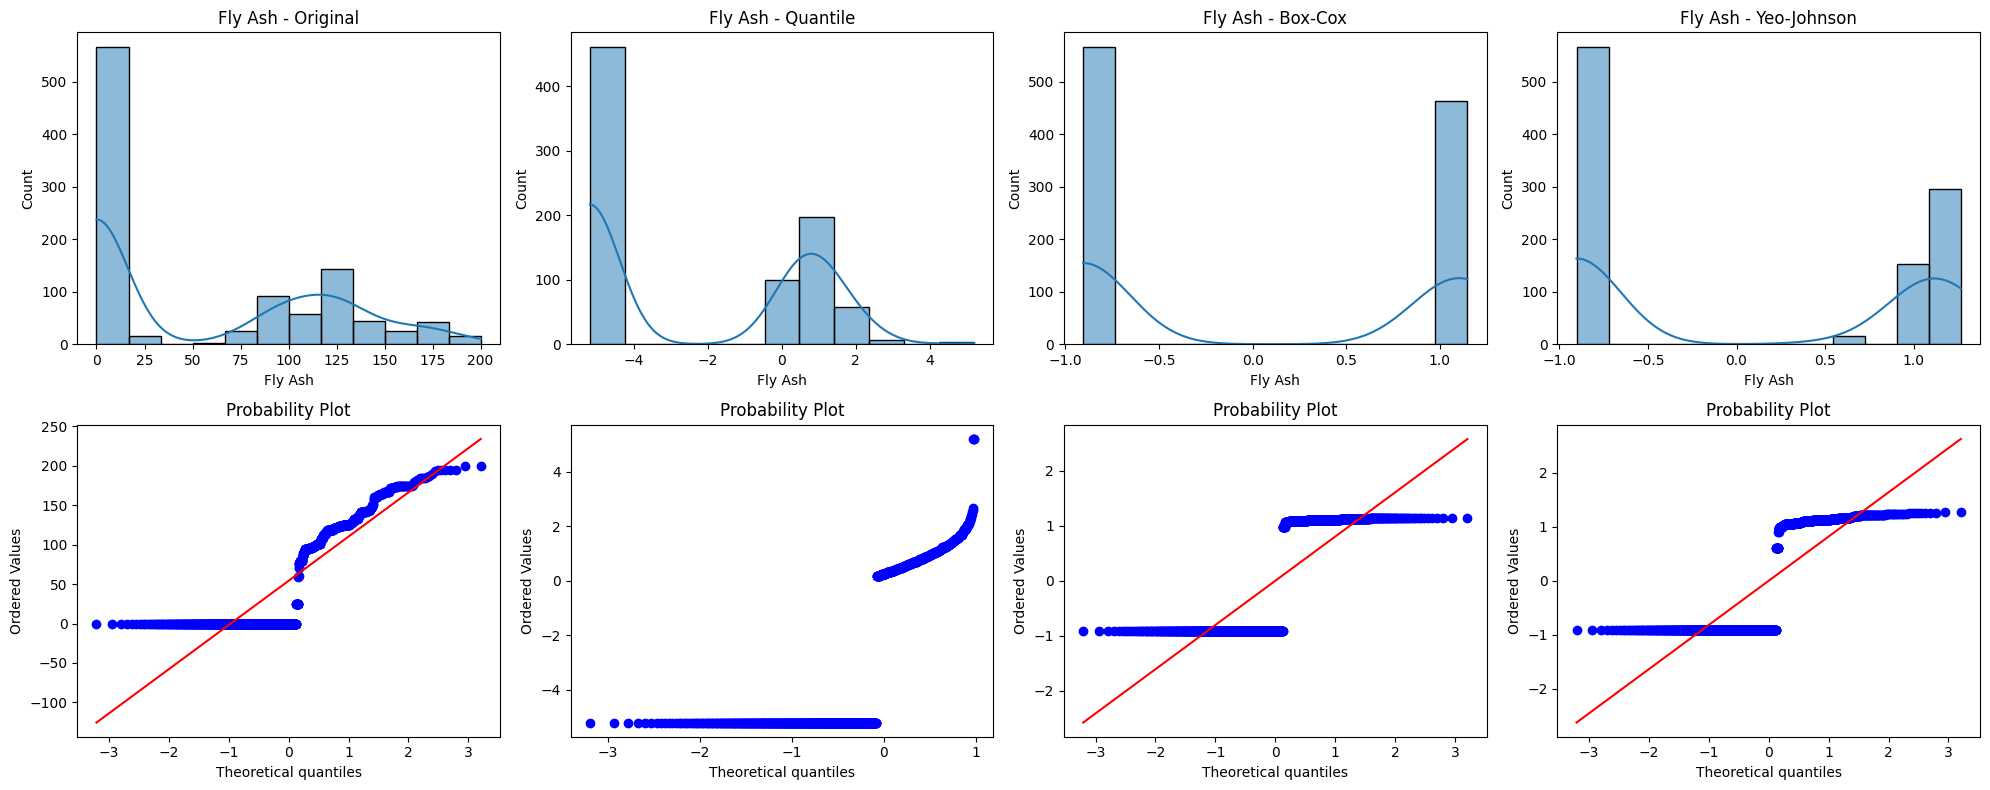

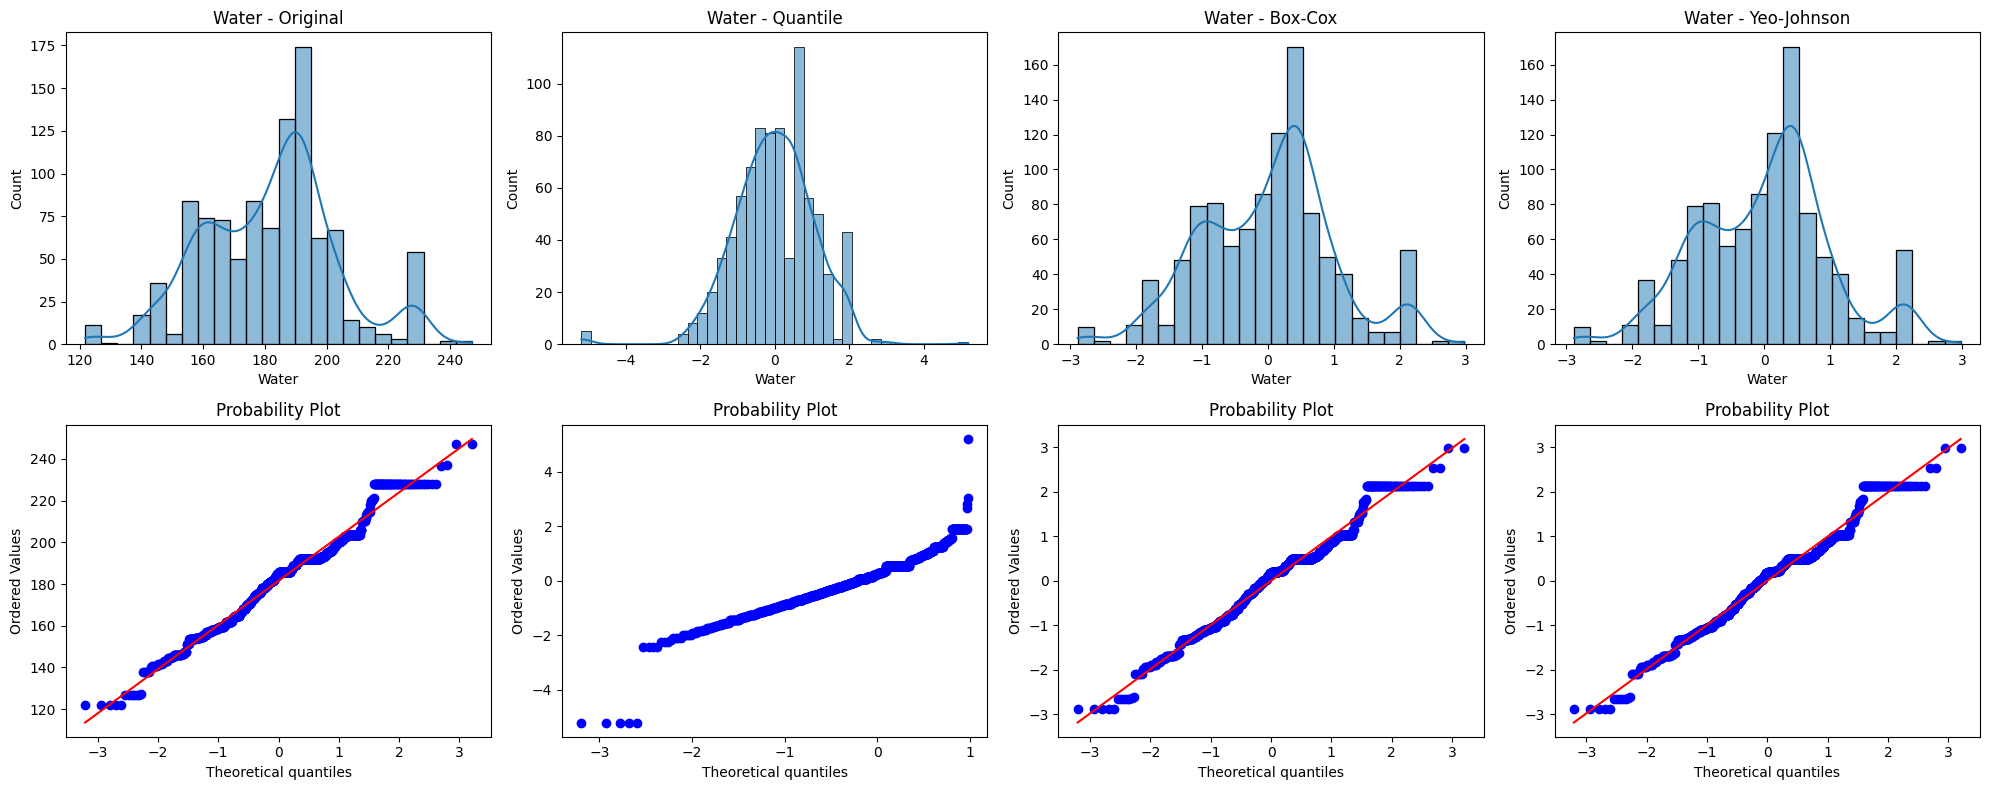

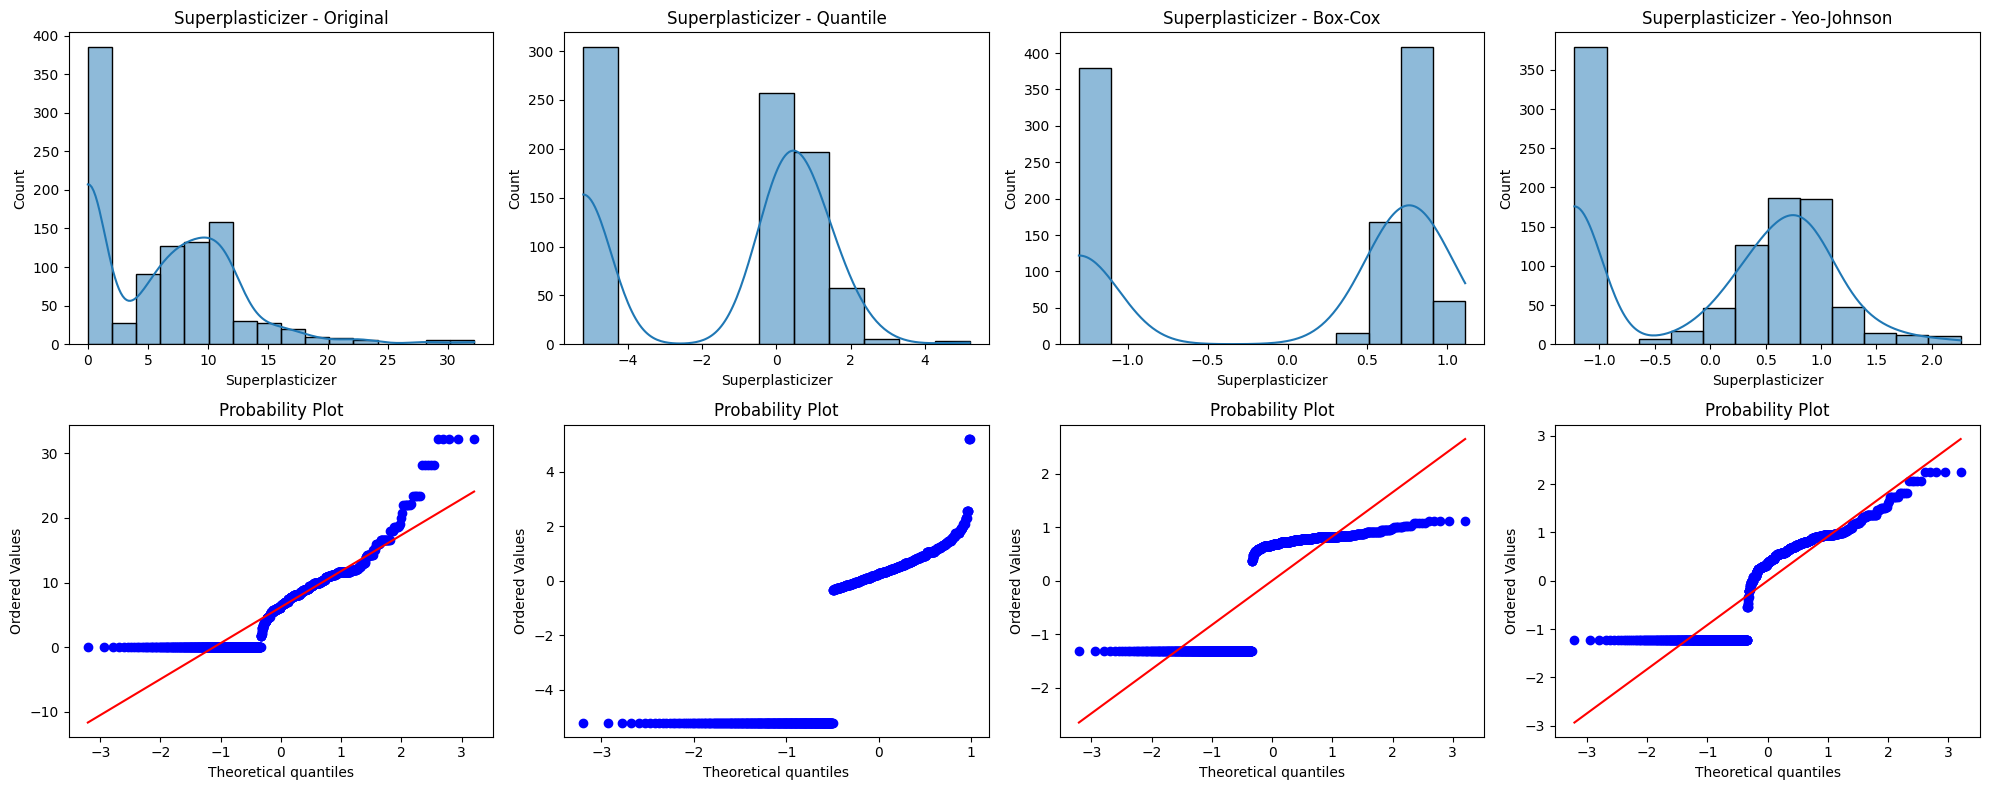

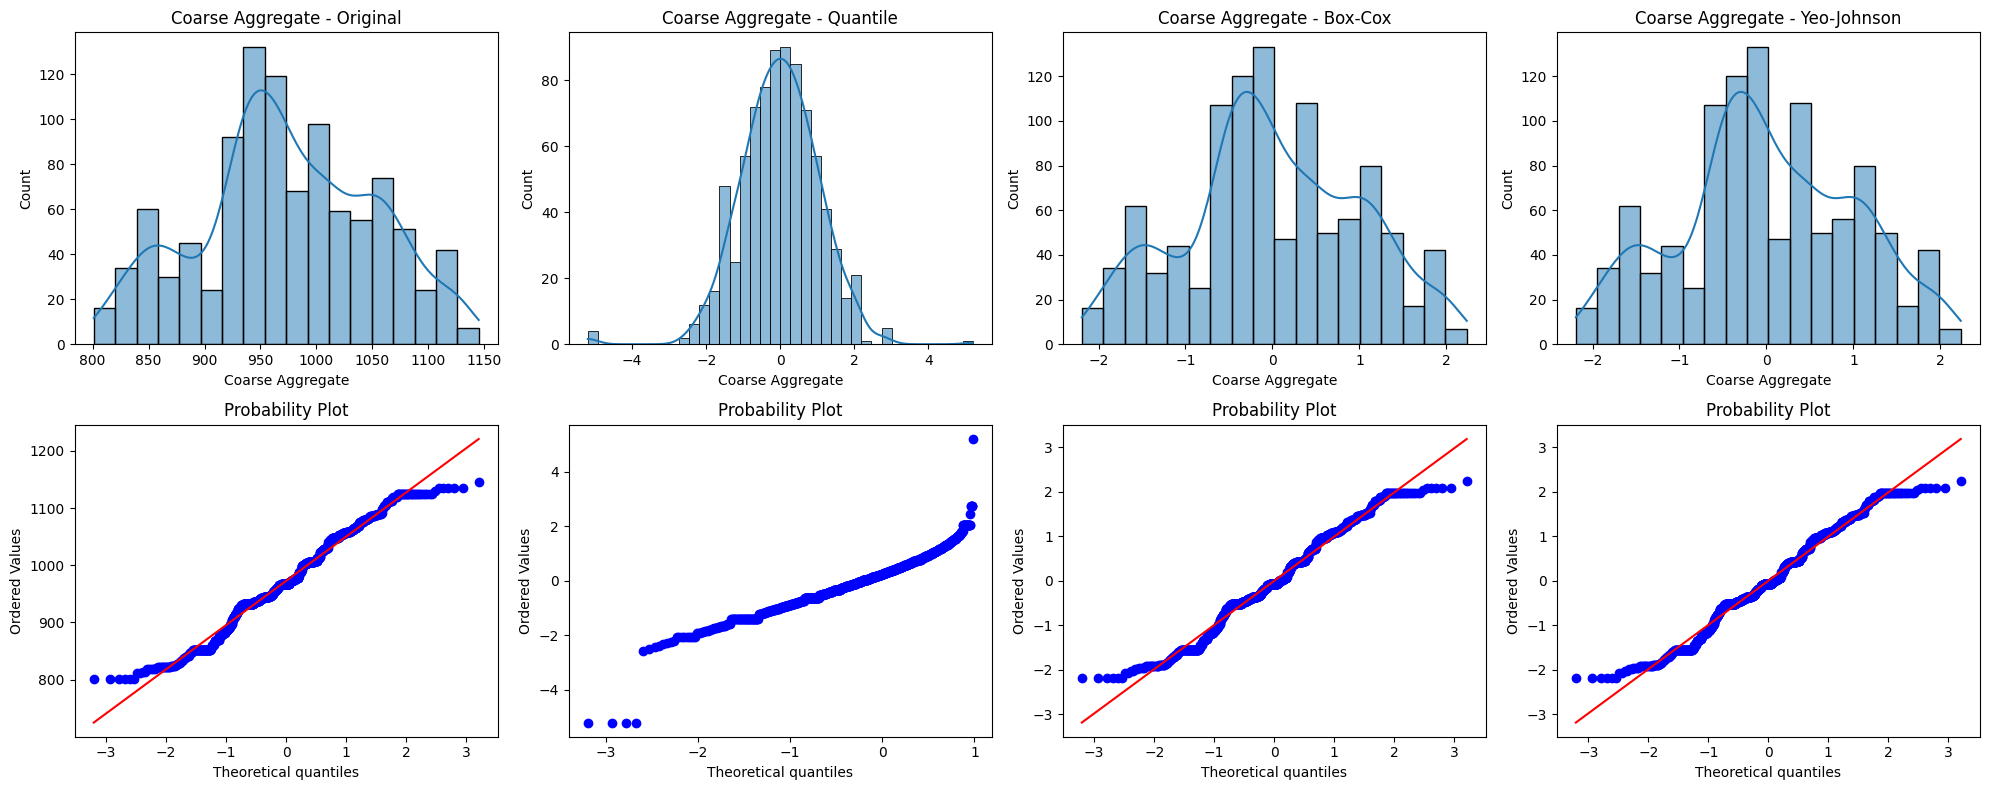

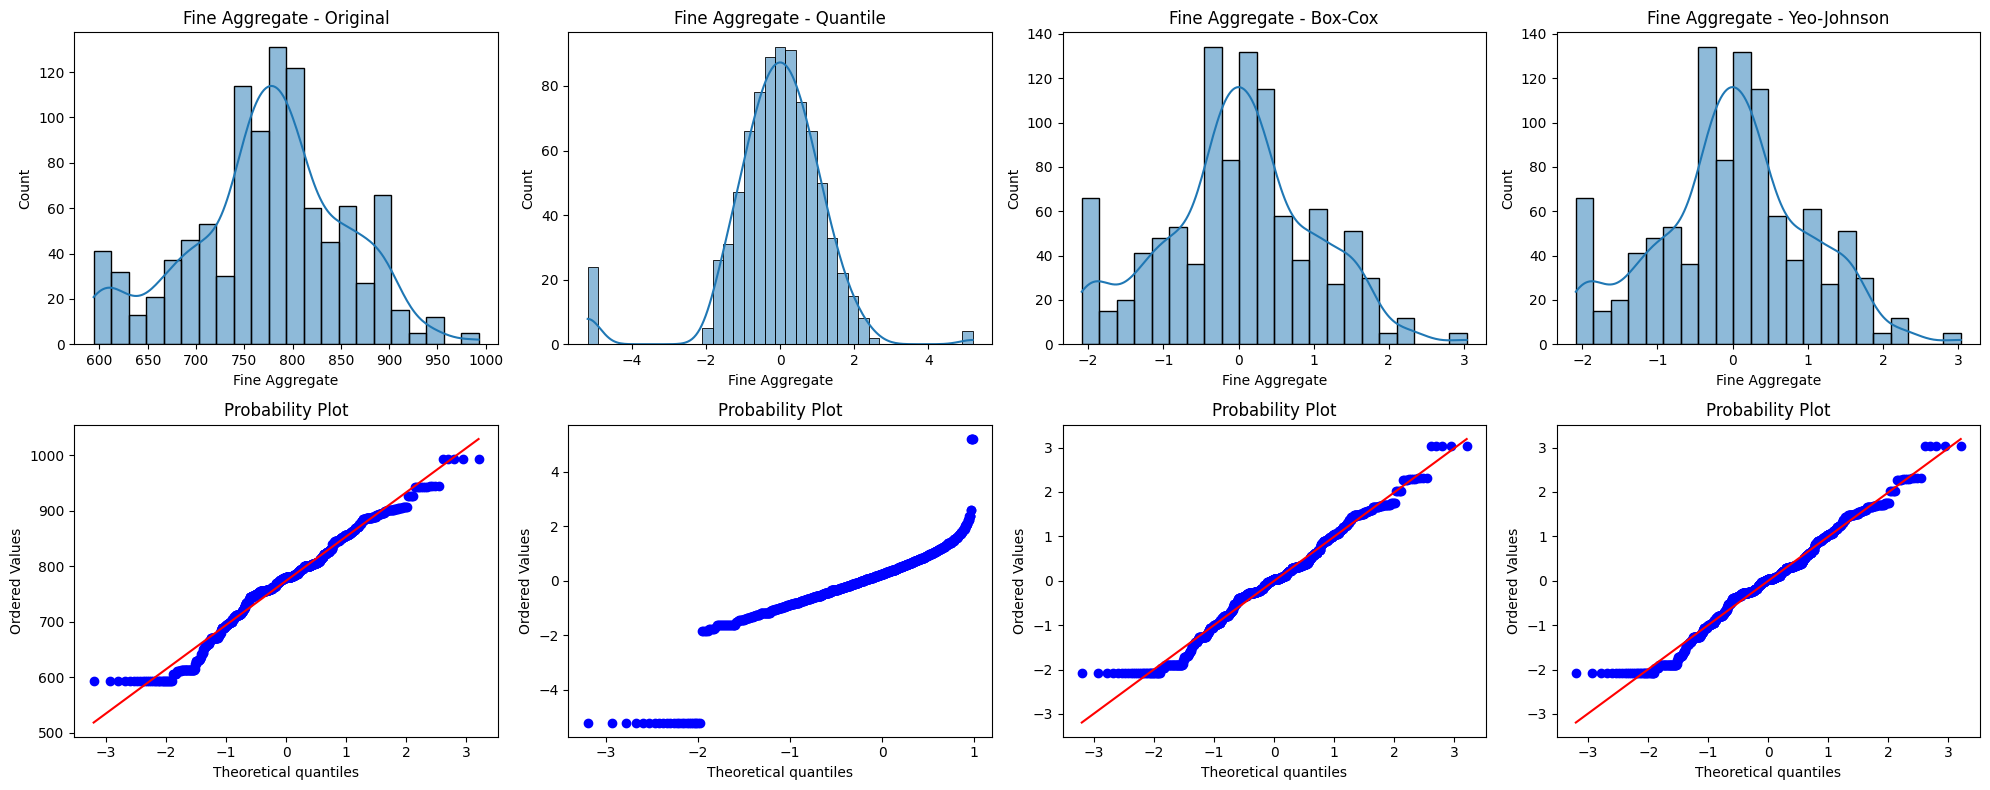

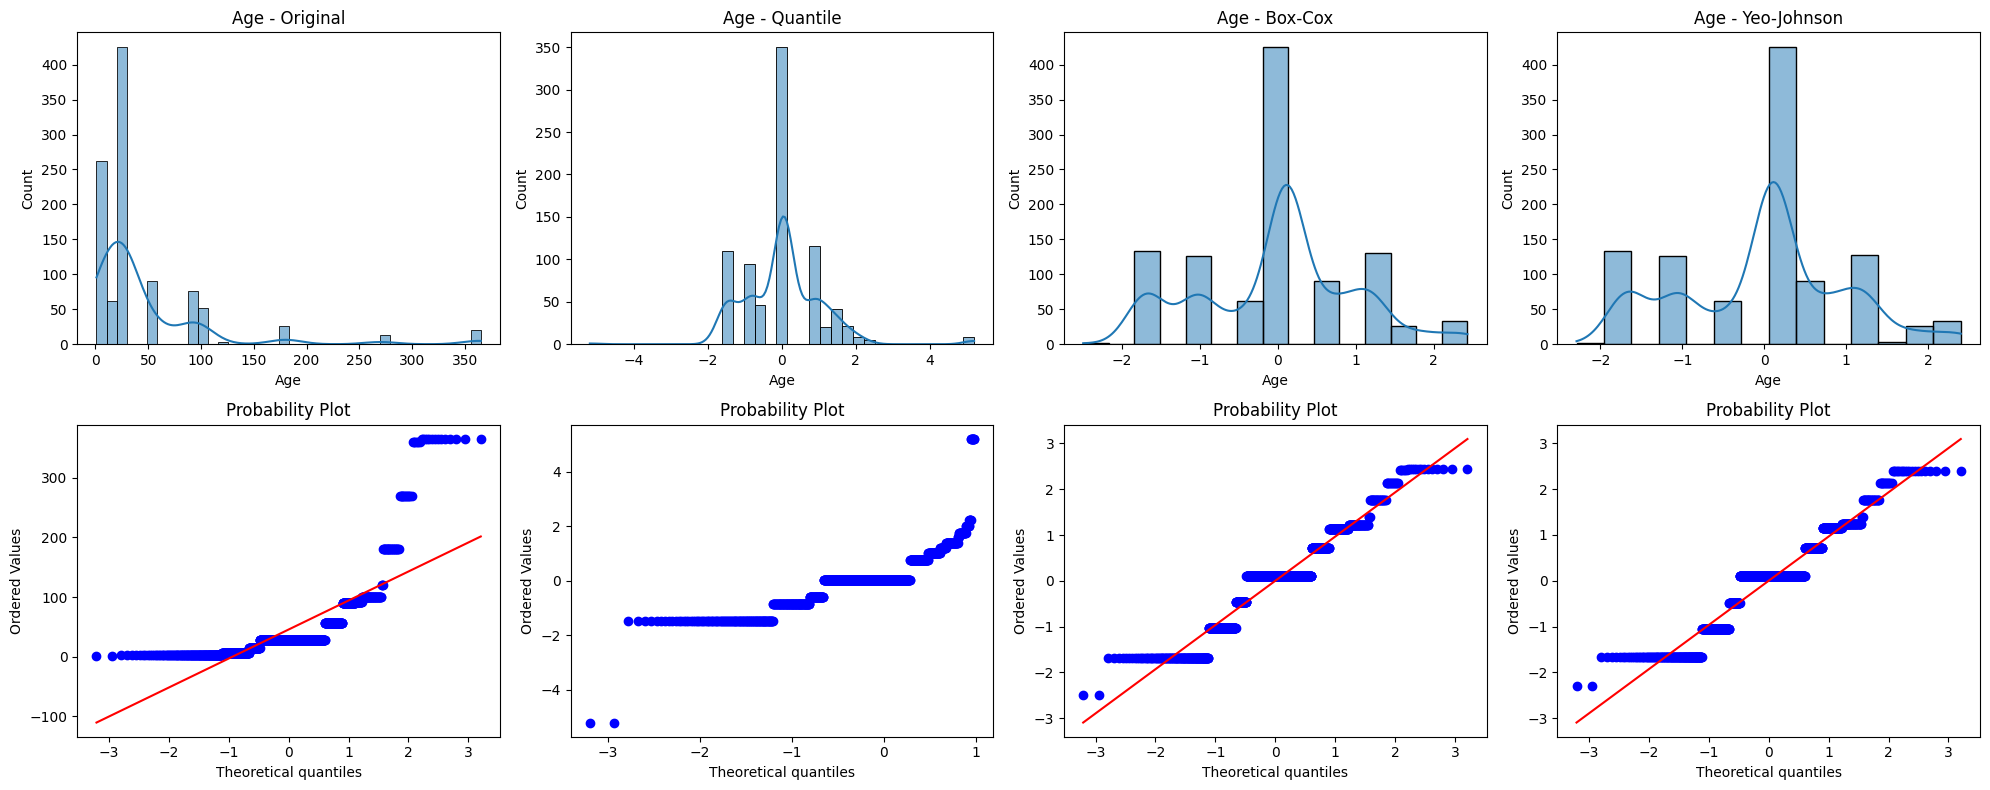

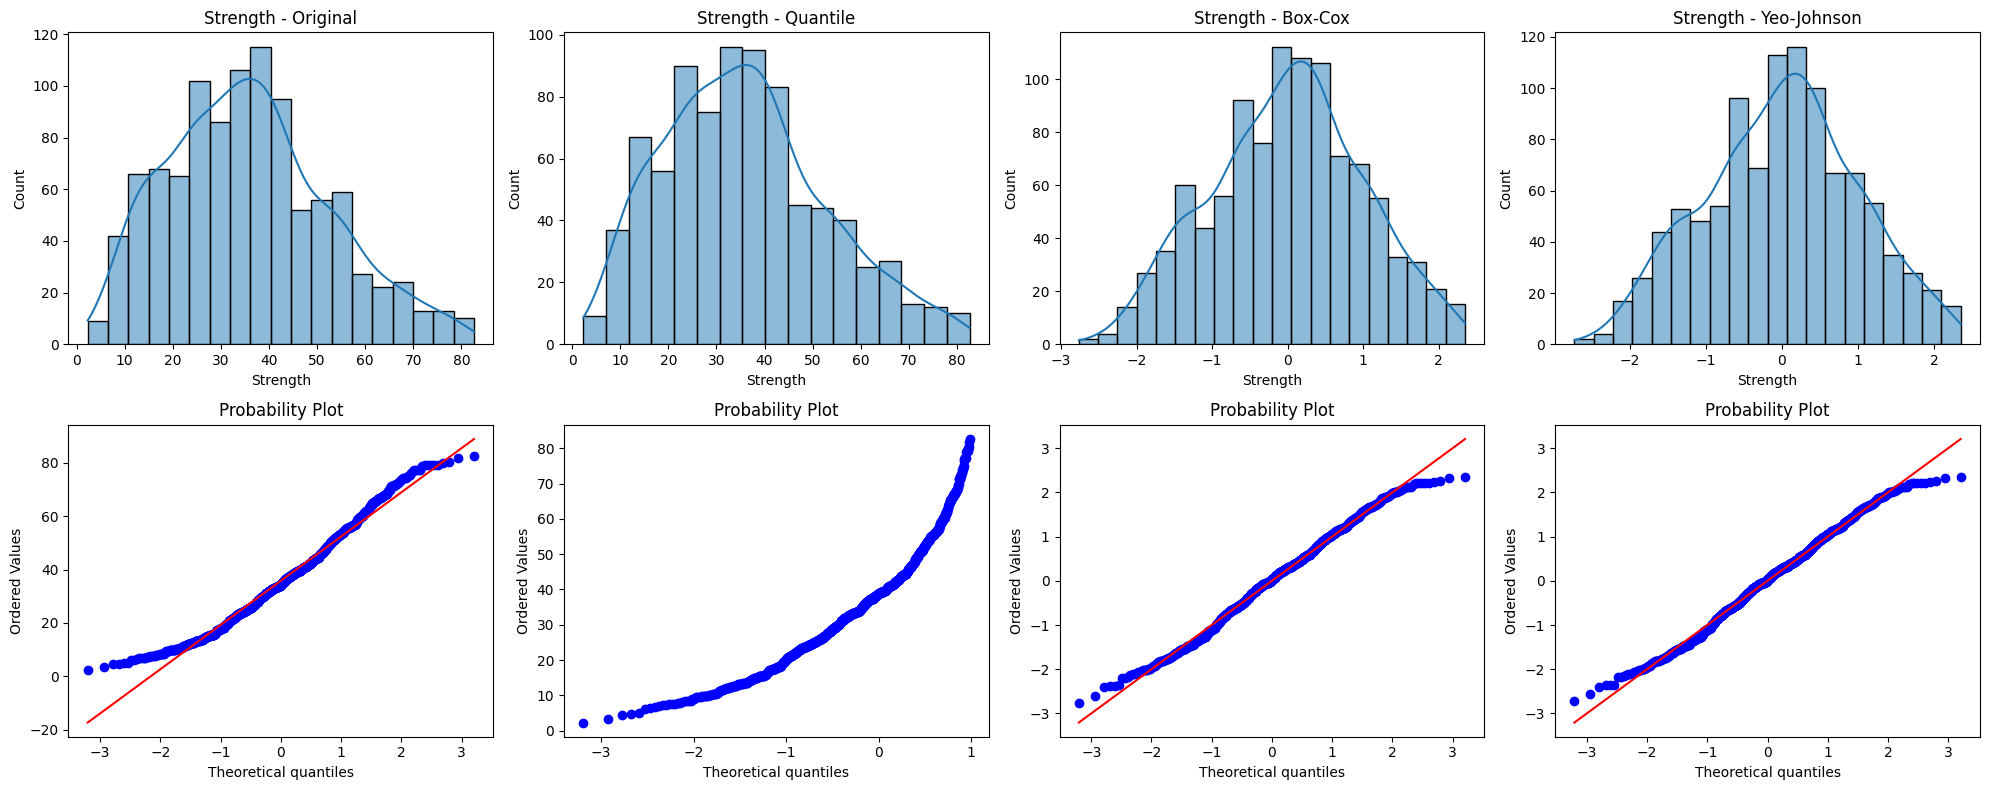

In [41]:
# plotting df, quantile transformer, box-cox, yeo-johnson
from sklearn.preprocessing import PowerTransformer 
# making box-cox object
pt_boxcox = PowerTransformer(method='box-cox')
boxcox = pt_boxcox.fit_transform(df + 0.000001)

# making yeo-johnson object
pt_yeojohnson = PowerTransformer(method='yeo-johnson')
yeojohnson = pt_yeojohnson.fit_transform(df)

# converting the both into data frames
boxcox = pd.DataFrame(boxcox, columns=df.columns)
yeojohnson = pd.DataFrame(yeojohnson, columns=df.columns)

# making a for loop to plot all the four graphs
for col in df.columns:
    plt.figure(figsize=(20, 8))  # Increased height for 2 rows
    
    # Row 1: Histograms
    plt.subplot(2, 4, 1)
    sns.histplot(df[col], kde=True)
    plt.title(f"{col} - Original")
    
    plt.subplot(2, 4, 2)
    sns.histplot(data[col], kde=True)
    plt.title(f"{col} - Quantile")
    
    plt.subplot(2, 4, 3)
    sns.histplot(boxcox[col], kde=True)
    plt.title(f"{col} - Box-Cox")
    
    plt.subplot(2, 4, 4)
    sns.histplot(yeojohnson[col], kde=True)
    plt.title(f"{col} - Yeo-Johnson")
    
    # ************************************************************************
    # Row 2: QQ Plots
    plt.subplot(2, 4, 5)
    stats.probplot(df[col], dist='norm', plot=plt)
    
    plt.subplot(2, 4, 6)
    stats.probplot(data[col], dist='norm', plot=plt)
    
    plt.subplot(2, 4, 7)
    stats.probplot(boxcox[col], dist='norm', plot=plt)
    
    plt.subplot(2, 4, 8)
    stats.probplot(yeojohnson[col], dist='norm', plot=plt)
    
    plt.tight_layout()
    plt.show()

In [42]:
"""    
WHEN TO USE COLUMN, POWER, AND QUANTILE TRANSFORMERS

ColumnTransformer is not really a transformation method but a pipeline tool. Use it when you need to apply different transformations to different columns in your dataset. 
For example, scaling numerical features while one-hot encoding categorical features, or applying log transform to some columns and StandardScaler to others. It's about workflow organization, not data distribution.

PowerTransformer (Box-Cox and Yeo-Johnson) works best for moderate skewness (roughly -1 to -3 or +1 to +3). 
Box-Cox only handles positive values and is slightly more powerful, while Yeo-Johnson works with zero and negative values too. These methods try to make data Gaussian through mathematical power functions. 
They work well when your data has a somewhat predictable pattern of skewness.

QuantileTransformer is your heavy-duty solution for extreme skewness or when you have outliers. It transforms data to follow a uniform or normal distribution by mapping values to their quantile positions. 
Use it when PowerTransformer fails to normalize your data, when you have multi-modal distributions, or when outliers are resistant to other methods. The tradeoff is that it can distort relationships between variables since it's a rank-based transformation.

Quick decision flow: Try PowerTransformer first for skewed data. If skewness remains high (>1 or <-1 after transformation) or you have stubborn outliers, switch to QuantileTransformer. 
Use ColumnTransformer throughout to organize your preprocessing pipeline.




"""

"    \nWHEN TO USE COLUMN, POWER, AND QUANTILE TRANSFORMERS\n\nColumnTransformer is not really a transformation method but a pipeline tool. Use it when you need to apply different transformations to different columns in your dataset. \nFor example, scaling numerical features while one-hot encoding categorical features, or applying log transform to some columns and StandardScaler to others. It's about workflow organization, not data distribution.\n\nPowerTransformer (Box-Cox and Yeo-Johnson) works best for moderate skewness (roughly -1 to -3 or +1 to +3). \nBox-Cox only handles positive values and is slightly more powerful, while Yeo-Johnson works with zero and negative values too. These methods try to make data Gaussian through mathematical power functions. \nThey work well when your data has a somewhat predictable pattern of skewness.\n\nQuantileTransformer is your heavy-duty solution for extreme skewness or when you have outliers. It transforms data to follow a uniform or normal dist